<a href="https://colab.research.google.com/github/SergeyMalyshevsky/Samsung-Neural-Network-Course/blob/master/Samsung_5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

9920512it [00:02, 3921902.03it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 56460.98it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 784452.69it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21938.38it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

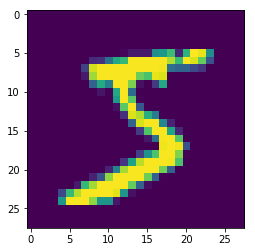

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
# разжимаем массив
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, 
                                 kernel_size=5, padding=2)
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, 
                                 kernel_size=5, padding=0)
    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    
    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act3 = torch.nn.Tanh()
    
    self.fc2 = torch.nn.Linear(120, 84)
    self.act4 = torch.nn.Tanh()
    
    self.fc3 = torch.nn.Linear(84, 42)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    
    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)
    
    # преобразуем тензор в одномерный
    # первый параметр - размер батча, второй - размер вектора
    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)
    
    return x
  
lenet5 = LeNet5()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [0]:
loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(lenet5.parameters(), momentum=0.7, lr=0.01)

In [52]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
  order = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train), batch_size):
    # обнуляем градиенты
    optimizer.zero_grad()
    
    # вычисляем какие картинки пойдут в текущий батч
    batch_indexes = order[start_index:start_index+batch_size]
    
    # переносим текущий батч на GPU
    X_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)
    
    # прогоняем батч через сеть
    preds = lenet5.forward(X_batch)
    
    # cчитаем loss
    loss_value = loss(preds, y_batch)
    # считаем градиенты
    loss_value.backward()
    
    # делаем шаг градиентного спуска
    optimizer.step()
  
  # считаем качество на отложенной выборке
  test_preds = lenet5.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test).data.cpu())
  
  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
  test_accuracy_history.append(accuracy)
  
  print(accuracy)

tensor(0.9909)
tensor(0.9906)
tensor(0.9906)
tensor(0.9906)
tensor(0.9904)
tensor(0.9899)
tensor(0.9910)
tensor(0.9905)
tensor(0.9909)
tensor(0.9915)
tensor(0.9907)
tensor(0.9904)
tensor(0.9905)
tensor(0.9906)
tensor(0.9902)
tensor(0.9910)
tensor(0.9905)
tensor(0.9902)
tensor(0.9910)
tensor(0.9906)
tensor(0.9911)
tensor(0.9903)
tensor(0.9907)
tensor(0.9901)
tensor(0.9904)
tensor(0.9903)
tensor(0.9905)
tensor(0.9908)
tensor(0.9911)
tensor(0.9907)
tensor(0.9907)
tensor(0.9915)
tensor(0.9904)
tensor(0.9903)
tensor(0.9910)
tensor(0.9910)
tensor(0.9908)
tensor(0.9906)
tensor(0.9908)
tensor(0.9914)
tensor(0.9906)
tensor(0.9905)
tensor(0.9907)
tensor(0.9912)
tensor(0.9910)
tensor(0.9907)
tensor(0.9909)
tensor(0.9911)
tensor(0.9909)
tensor(0.9908)
tensor(0.9912)
tensor(0.9908)
tensor(0.9907)
tensor(0.9909)
tensor(0.9906)
tensor(0.9910)
tensor(0.9911)
tensor(0.9906)
tensor(0.9906)
tensor(0.9909)
tensor(0.9905)
tensor(0.9904)
tensor(0.9904)
tensor(0.9908)
tensor(0.9910)
tensor(0.9906)
tensor(0.9

KeyboardInterrupt: ignored

In [46]:
lenet5.forward(X_test)

tensor([[-1.0771,  0.4681, -1.5395,  ..., -2.3674, -2.0850, -2.5198],
        [ 1.5867,  1.4303, 15.3237,  ..., -0.9484, -0.8055, -1.7037],
        [-4.0295, 16.0017, -2.1210,  ..., -2.5556, -1.7517, -2.5773],
        ...,
        [-2.8314, -0.2892, -3.4478,  ..., -3.2879, -2.7892, -3.5934],
        [-2.4728, -3.8566, -4.7862,  ..., -2.7754, -2.2963, -3.1737],
        [ 1.4061, -2.7816,  2.6993,  ..., -2.2917, -1.9780, -3.0256]],
       device='cuda:0', grad_fn=<AddmmBackward>)

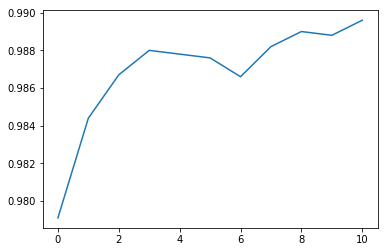

In [49]:
plt.plot(test_accuracy_history)
#plt.plot(test_loss_history)